<a href="https://colab.research.google.com/github/Joel-Bauer/PytorchTutorial/blob/main/COLAB_MNIST_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to PyTorch!
The purpose of this little tutorial is to introduce you to the basics of the PyTorch deep learning package, and how to structure a small project.
We will use a classic deep learning introductory problem, classification of single hand writen digets from the MNIST databse (Modified National Institute of Standards and Technology database).


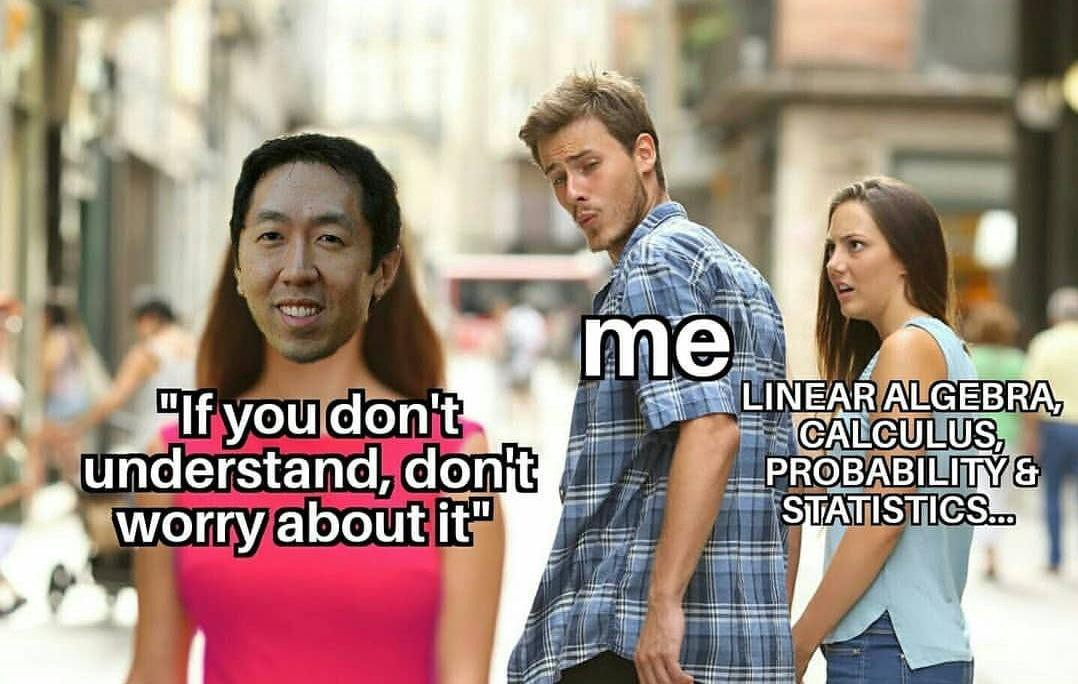
[](https://)

# Summary
- Installation and Setup
- 0) Import Torch and check if you have a GPU
- 1) Download MNIST Dataset and plot it
- 2) Call a Model (we provide a few to try)
- 3) Helper Functions for Training
- 4) Training Loop
- 5) Evaluation Performance
- 6) Saving and Reloading Models 

# Installation and Setup

Before we begin, please make sure to go to `File > Save a Copy in Drive`. This makes sure that any changes you make are saved just for you, and not the whole group! Once you've copied the file, go to `Runtime > Change Runtime Type`, and select __GPU__ under Hardware Accelerator.

In [ ]:
import os
from google.colab import drive
drive.mount("/content/gdrive")

%cd gdrive/MyDrive/

if not os.path.isdir(os.path.join(os.getcwd(), "PytorchTutorial")):
  ! git clone https://github.com/Joel-Bauer/PytorchTutorial.git
  %cd PytorchTutorial
  ! pip install -r requirements.txt
else:
  %cd PytorchTutorial
  ! git pull origin main
  ! pip install -r requirements.txt

# Imports
Just run the cell below

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

%load_ext autoreload
%autoreload 2

# Helper and Plotting Functions
Just run the cell below

In [ ]:
def plot_examples(imgs, labels, Label_predictions):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        figure.add_subplot(rows, cols, i) 
        if len(Label_predictions) < 1:
            plt.title(np.array2string(labels[i]) )
        else:
            plt.title(np.array2string(labels[i]) + '(' + np.array2string(Label_predictions[i]) + ')')
        plt.axis("off")
        plt.imshow(imgs[i].squeeze(), cmap="gray")
    plt.show()

# 0) Import torch and check if our workstation has a CUDA enabled GPU 

In [ ]:
import torch as torch # import the pytorch library

# if a cuda enabled GPU device is available get a handle(?) to it, otherwise create a handle to the cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device 

# 1) Getting and Loading Data

## 1.1) Download MNIST data from the torchvision library. 
Torchvision needs to be imported separately. 

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# pytorch has several datasets you can download, including the MNIST hand-written digit
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True          
)

Above we have downloaded the training set. Fill out the code below to to download the test set.

In [ ]:
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor(), 
    download = True 
)

## 1.2) Let's have a look at the dataset we've just downloaded

The MNIST data is composed of images and their corresponding labels.
To plot an example of the data, we will use matplotlib.

In [ ]:
print(train_data) 
print(test_data)

# call an example of an image and its label. What are the dimensions of the image and what is the label for this example?
img, label = train_data[0] 
print(img.shape) 
print(label) 

In [ ]:
# plot the example image 
figure = plt.figure(figsize=(3, 3))
plt.imshow(img.squeeze(), cmap="gray") 
plt.title(label)
plt.axis("off");

## 1.3) Loading your own data

Above we downloaded an existing dataset from torchvision. In many cases you will want to import your own data from .mat, .npy and .npz files. Below is an example of how that might work.

In [ ]:
## save MNIST data as numpy arrays

# imgs = train_data.data.detach().numpy()
# labels = train_data.targets.detach().numpy()
# np.savez('MNIST_train.npz',imgs=imgs,labels=labels)

# imgs = test_data.data.detach().numpy()
# labels = test_data.targets.detach().numpy()
# np.savez('MNIST_test.npz',imgs=imgs,labels=labels)

In [ ]:
# # Loading from disk
# data = np.load('MNIST_train.npz') # load data from .npz file
# labels=data['labels']
# imgs=data['imgs'] 
# imgs=torch.from_numpy(imgs) # convert numpy array to torch tensor
# imgs=imgs.to(torch.float32) # specify dtype as float32 (dtype must match the model dtype whos default is usually float32)
# train_data = torch.utils.data.TensorDataset(imgs,torch.from_numpy(labels))

# # same thing for the test set
# data = np.load('MNIST_test.npz')
# imgs=torch.from_numpy(data['imgs']).to(torch.float32)
# labels=data['labels']
# test_data = torch.utils.data.TensorDataset(imgs,torch.from_numpy(labels))

## 1.4) Create a data loader

The `DataLoader` function wraps an iterable around a DataSet class. This provides an easy way of sampling from the dataset in an efficient way. This is also where we can specifiy the batch size, as well as introduce data transforms that can be applied each time we sample from the data.

- **batch size**: The size of your data sample used for each optimization step. This is a hyperparameter, i.e. a variable you can optimize to improve good model performance quickly.

- **transforms**: We might need to rescale our images. Or we would like to augment our training data, e.g. by flipping the images horizontally or introducing noise.

In [ ]:
from torch.utils.data import DataLoader

DataLoaderbatchsize = 64 # This is usually a multiple of 2 between 16 and 512 and will depend on your CPU/GPU size

loaders = { # Library of data loader functions
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size = DataLoaderbatchsize, 
                                          shuffle = True, # We usually want to randomly sample a new subset of our data
                                          num_workers = 1), # This variable allows us to multithread dataloading, 
                                                          # which is useful if we have a dataset which does not fit onto the RAM
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size = DataLoaderbatchsize, 
                                          shuffle = True, 
                                          num_workers = 1),
}

Let's call the data loader to call one batch and plot the examples in that batch. We have writen a plotting function that plots a few examples with labels in one figure for you.

In [ ]:
training_data_iterable = iter(loaders['train'])    # create an iterable 
img, label = next(training_data_iterable)          # calls the first randomly sampled batch of examples
plot_examples(img, label, [])                      # plots a few examples

# 2) Create or call a model
This is the fun bit! We wrote a couple of models in this tutorial for you and for now we will just use one of these, but feel free to go back and modify them or make another one from scratch. 

In this digit classification exercise, the major constraints of your model are the size of the input layer, which needs to match your input data (channels \* height \* width -> 1 \* 28 \* 28), and the size of your output layer, which needs to match the number of possible classes/lables (0-9 -> 10). 

#### Feed Forward Models

- **LFF**: No hidden layers. This is a linear model because it cannot learn nonlinear relationships.

- **DFF_tiny**: This model has 10 hidden units

- **DFF**: Still a fairly shallow model (not many hidden layers), but with more hidden units

#### Convolutional Models

- **ConvNet1**: The first two layers are convolutional layers, which are then followed by one fully connected feed forward layer

We will use the DFF model for our example

In [ ]:
from torchsummary import summary 
from Models import DFF as model    # try other models too!

net = model().to(device)    # Call an instance of the model

summary(net, (1, 28, 28))   # this gives us a convenient way of quickly looking at the structure and size of our model. 

# We will want to cellect the model performance as we train it. So let's initiate this list here
loss_train = [] # loss collector
loss_test = []

### 2.1) Visualization
It is often usefull to visualize our models in the form of flow charts, especially when they get large and complicated. There are several tools you can use. Try using the [Netron online app](https://netron.app). You will need to generate a `.onnx` file by running the cell below. Then right click on the generated file in the sidebar to download. Drag-and-drop the `.onnx` file into the web app.

In [ ]:
import torch.onnx

img, label = next(iter(loaders['train'])) # get a batch
torch.onnx.export(net, img.to(device), 'MNIST_DFF.onnx', 
                  export_params=True, 
                  input_names=['image'], 
                  output_names=['label'],
                  dynamic_axes={'image': {0: 'batch_size'},'label' : {0: 'batch_size'}}
                  ) 

# 3) Helper functions for training
We will want to create a couple helper functions to train and evaluate our model. 

- **loss function**: This calculates the difference between the predicted labels and the true labels across your batch. There are many loss functions, but usually there is a standard loss function for the problem you are working on. For Classification, Cross Entropy is commonly used. This loss is then used to calculate the gradient across the model, which in turn is used to update the weights and biases in the model in a process called gradient decent.

- **gradient calculator**: just kidding! Pytorch takes care of this for you. 

- **optimizer**: After we calculate the loss, we need to apply gradient decent. The aim is to decrease the loss. However, there are a number of ways this can be applied. We therefore need to choose an optimizer function.

- **accuracy**: We usually also want to know the proportion of correctly identified examples, even though that is not used for gradient descent.

- **Wrapper**: It is helpful to write a function, which applies the above steps in the correct order and only when appropriate (e.g. you should disable optimization when applying your model to test data).  

In [ ]:
## Loss function
from torch import nn

Loss_func = nn.CrossEntropyLoss()
# Loss_func = nn.MSELoss() # Alternative: would need to convert label to one-hot-vector -> nn.functional.one_hot(label,num_classes=10)

In [ ]:
## accuracy
def accuracy_calc(labels,labels_pred_int): 
    # labels: true labels (in integer from, not a one-hot-vector)
    # labels_pred_int: predicted labels (in integer from, not a vector of probabilities)
    labels = labels.cpu().detach().numpy() # to use numpy we need to move the tensor of labels off the GPU and convert it to a numpy array
    labels_pred_int = labels_pred_int.cpu().detach().numpy()
    return 100 * (labels_pred_int == labels).sum().item() / np.shape(labels)[0] # Here, we calculate the percent correctly predicted labels

There are a number of different optimization algorithms and components thereof. 

- **Batch gradient descent**: calculate the gradient across the entire training data set and then perform one optimization step.

- **Stocastic gradient descent (SGD)**: calculate the gradient and apply an optimization step for each training sample independently.

- **Mini-batch gradient descent**: for each batch (e.g. 32 training examples) calculate the gradient and apply one step of optimization. Usually preferable to the batch gradient decent or true SGD.

- **Momentum**: uses a rolling average of the gradient, so that noise across batches is minimized. This smooths the learning "trajectory".

- **Adaptive learning rate**: when we are far away from the global optimum a larger learning rate is advantageous as it speeds up progress, but as we approach the global minimum small steps are better. 

Note: confusingly, the PyTorch function `torch.optim.SGD` does not perform Stocastic Gradient Descent strictly speaking. It will optimize based on the accumulated gradient, of which the step size is defined by us. You will see what this means below. 

In [ ]:
## optimizer
from torch import optim

# We will use 
lr = 0.01 
momentum = 0.5 # try 0
optimizer = optim.SGD(net.parameters(), momentum=momentum, lr=lr) # stocastic gradient decent
# optimizer = optim.Adam(net.parameters()) # more advanced alternative

Let's wrap things up!

In [ ]:
## Wrapper function
def run_model(img, labels, model, optimizer, Loss_func, train=False):
  
    if train: # only important in specific instances (e.g. if your model has dropout layers or variational layers)
        model.train()
    else:
        model.eval()
    
    optimizer.zero_grad() # otherwise gradients will accumulate. 

    labels_pred = model(img)  # run model and get label predictions
    labels_pred_int = labels_pred.argmax(axis=1) # our model spits out a probability for each category (label) to be true. This line gets the index of max probability for each example.
    loss = Loss_func(labels_pred, labels) # calculate the loss (only uses one channel)
    accuracy = accuracy_calc(labels, labels_pred_int) # calculate the % correct predictions

    # we only want this next bit to be true when specified, i.e. when we are training the model
    if train:
        # backprob and update
        loss.backward() # calculates the gradient based on the current loss
        optimizer.step() # applies one optimization step
    
    return loss, labels_pred, labels_pred_int, accuracy

It's a good idea to check things are working before training your model. Get a training example batch, run it through the model using the wrapper function above and print the outs.

In [ ]:
# check its all working
img, label = next(iter(loaders['train'])) # get a batch
img = img.to(device) 
label = label.to(device) 
batch_loss, label_pred, label_pred_int, accuracy = run_model(img, label, net, optimizer, Loss_func) 

label=label.cpu().detach().numpy()
batch_loss=batch_loss.cpu().detach().numpy()
label_pred=label_pred.cpu().detach().numpy()
label_pred_int=label_pred_int.cpu().detach().numpy()

print('label:            ' + np.array2string(label))
print('label prediction: ' + np.array2string(label_pred_int))
print('label weights first example: ' + np.array2string(label_pred[0]*100, precision=0, suppress_small=True))
print('loss: ' + np.array2string(batch_loss))
print('accuracy: ' + str(accuracy) + '%')

# 4) Training time

It's finally time to train our model. We will do this using two `for` loops. The nested loop will sample batches of data and optimize the model on each iteration until all examples in the training set have been used once. The second loop will repeat these passes over the training set a given number of times (epochs), as well as calculate and plot the loss for the training and test set at the end of each epoch.

But first, let's caculate the training and test loss before any optimization has occured.

In [ ]:
if len(loss_train)<1: # if no training has happened yet save initial loss value
    img, label = next(iter(loaders['train'])) # get one batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img, label, net, optimizer, Loss_func)
    loss_train.append(batch_loss.cpu().detach().numpy())

if len(loss_test)<1: # if no training has happened yet save initial loss value
    img, label = next(iter(loaders['test'])) # get one batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img, label, net, optimizer, Loss_func)
    loss_test.append(batch_loss.cpu().detach().numpy())

We will use the `tqdm` package (giving us a progress bar) to keep track of the progress through the training set.

In [ ]:
# training loop
epochs = 30 # 

plt.figure()
for ep_n in range(epochs):

    for img,label in tqdm(loaders['train']):
        img = img.to(device)
        label = label.to(device)
        net.train()
        run_model(img, label, net, optimizer, Loss_func, train=True)

    # training set loss
    img, label=next(iter(loaders['train'])) # get a batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img, label, net, optimizer, Loss_func)
    loss_train.append(batch_loss.cpu().detach().numpy())

    # test set loss
    img, label=next(iter(loaders['test'])) # get a batch
    img = img.to(device)
    label = label.to(device)
    batch_loss, _, _, _ = run_model(img, label, net, optimizer, Loss_func)
    loss_test.append(batch_loss.cpu().detach().numpy())

    # plot the losses
    plt.clf()
    train_handle = plt.plot(loss_train, color='blue', label='training set')
    test_handle = plt.plot(loss_test, color='red', label='test set')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    display.clear_output(wait=True) # necessary in order to refresh the plot, otherwise it will print a new plot each epoch
    display.display(plt.gcf())

# 5) Evaluating performance

If all has gone well, our loss function should have decreased substantially and reached a plateau. Or you've gotten bored, cut off the training early and just see how well the model is doing right now.

To get a feeling of for the model's performance, we will get multiple batches of test data, caculate the classificiation accuracy of the this set, and then plot a few examples.

In [ ]:
# check its all working
loader_temp = iter(loaders['test'])
img, label = next(loader_temp) # get a batch

for i in range(10): # get multiple batches to get more accurate estimates
    img_temp, label_temp = next(loader_temp)
    img = torch.cat((img, img_temp), dim=0)
    label = torch.cat((label, label_temp), dim=0)

img = img.to(device)
label = label.to(device)
batch_loss, label_pred, label_pred_int, accuracy = run_model(img, label, net, optimizer, Loss_func)


img = img.cpu().detach().numpy()
label = label.cpu().detach().numpy()
batch_loss = batch_loss.cpu().detach().numpy()
label_pred = label_pred.cpu().detach().numpy()
label_pred_int = label_pred_int.cpu().detach().numpy()

print('label: ' + np.array2string(label[0:31]))
print('label prediction: ' + np.array2string(label_pred_int[0:31]))
print('label weights first example: ' + np.array2string(label_pred[0] * 100, precision=0, suppress_small=True))
print('loss: ' + np.array2string(batch_loss))
print('accuracy: ' + str(round(accuracy, 2)) + '%')

plot_examples.plot(img, label, label_pred_int)

# 6) Saving and re-loading models

Now that we have a model that performs reasonably well, we want to save it. When you save models you save two things separately 1) the architecture, which we already saved, e.g. DFF.py, 2) the model weights or state.

In [ ]:
torch.save(net.state_dict(), 'MNIST_DFF1.pt')

When we want to retrieve a trained model, we also need to recover it in two stages.

In [ ]:
#load model 
from Models import DFF as model
net2 = model().to(device)

# load weights into model
net2.load_state_dict(torch.load('MNIST_DFF1.pt'))

# The End